In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

C:\Users\Chandan\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# OpenAI gym
import gym
env = gym.make('CartPole-v1')
axis = []
Reward = []
def main():
    num_episodes = 1000
    for _ in range(num_episodes):
        axis.append(_)
        state = env.reset() # reset() resets the environment
        episode_reward = 0 
        for t in range(1, 10000): # no of steps 
            action = select_action(state)
            state, reward, done, _ = env.step(action)
            env.render() # show 
            policy.rewards.append(reward)
            episode_reward += reward
            if done:
                break

        Reward.append(episode_reward)
        finish_episode_and_update()

In [3]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 24)
        self.dropout = nn.Dropout(p=0.6)
        
        self.affine2 = nn.Linear(24, 36)
        
        self.affine3 = nn.Linear(36, 2)
        
        self.saved_log_probs = []
        self.rewards = []
    
    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.affine2(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine3(x)
        return F.softmax(action_scores, dim=1)

policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()

In [4]:
from torch.distributions import Categorical
def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state) # FORWARD PASS
    m = Categorical(probs) # we are sampling from a distribution to add some exploration to the policy's behavior. 
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()

In [5]:
gamma = 0.99 # discount factor
def finish_episode_and_update():
    R = 0
    policy_loss = []
    returns = []
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    print("R", R)
    #print(returns)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward() # backward pass
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]


R 27.501966404214627
R 28.22694674017248
R 9.561792499119552
R 26.02996266117195
R 14.854222890512437
R 31.05509141309219
R 12.247897700103202
R 13.12541872310217
R 9.561792499119552
R 19.027213177874142


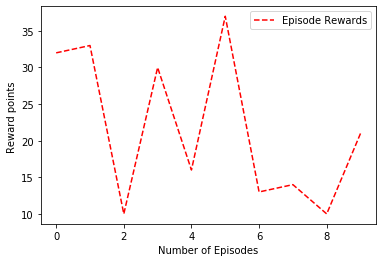

In [6]:
main()
plt.plot(axis,Reward, 'r--')
plt.xlabel('Number of Episodes')
plt.ylabel('Reward points ')
plt.legend(['Episode Rewards'])
plt.show()